In [23]:
from google.colab import drive
import os


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import interp1d

# Machine Data 로드
file_path = ("/content/drive/MyDrive/ASK_2026_FDC/Dataset/MACHINE_Data.xlsx")

# 파일 로드
if os.path.exists(file_path):
    print(f"{file_path}")
    if file_path.endswith('.xlsx'):
        df = pd.read_excel(file_path)
    elif file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    else:
        print("지원하지 않는 파일 형식입니다.")
else:
    raise FileNotFoundError(f"File not found: {file_path}")

print(f"Machine Data 로드 완료. Shape: {df.shape}")

# 식별 및 정답 Column
meta_cols = ['Wafer_ID', 'Time_Step', 'Label', 'Fault_Type', 'Time', 'Step Number']

# 학습에 사용할 센서 변수 선택 (숫자형 데이터만 선택)
sensor_cols = [c for c in df.columns if c not in meta_cols]
# 문자열 데이터 필터링 추가
sensor_cols = df[sensor_cols].select_dtypes(include=[np.number]).columns.tolist()

print(f"선택된 센서 변수 ({len(sensor_cols)}개):")
print(sensor_cols)

/content/drive/MyDrive/ASK_2026_FDC/Dataset/MACHINE_Data.xlsx
Machine Data 로드 완료. Shape: (12829, 25)
선택된 센서 변수 (19개):
['BCl3 Flow', 'Cl2 Flow', 'RF Btm Pwr', 'RF Btm Rfl Pwr', 'Endpt A', 'He Press', 'Pressure', 'RF Tuner', 'RF Load', 'RF Phase Err', 'RF Pwr', 'RF Impedance', 'TCP Tuner', 'TCP Phase Err', 'TCP Impedance', 'TCP Top Pwr', 'TCP Rfl Pwr', 'TCP Load', 'Vat Valve']


In [25]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 1. 전처리 함수 (패딩 기능 추가)
def preprocess_wafer_with_padding(wafer_data, seq_len):
    # 데이터 길이 확인
    data_len = len(wafer_data)

    # CASE 1: 데이터가 윈도우(seq_len)보다 짧은 경우 -> 패딩(Padding) 적용
    if data_len < seq_len:
        pad_size = seq_len - data_len
        # ((앞쪽패딩, 뒤쪽패딩), (피처 앞, 피처 뒤))
        # mode='edge': 마지막 값을 반복해서 채움 (추천)
        # mode='constant', constant_values=0: 0으로 채움
        padded_data = np.pad(wafer_data, ((0, pad_size), (0, 0)), mode='edge')

        # 패딩된 데이터는 길이가 딱 seq_len이므로, 윈도우 1개만 생성됨
        return np.array([padded_data]) # shape: (1, 100, features)

    # CASE 2: 데이터가 충분히 긴 경우 -> 정상적인 슬라이딩 윈도우
    sequences = []
    for i in range(data_len - seq_len + 1):
        sequences.append(wafer_data[i:i + seq_len])

    return np.array(sequences)

# 설정
SEQ_LEN = 100
experiments = ['l29', 'l31', 'l33']
datasets = {}

# (이전 코드의 루프 부분에서 함수만 교체하면 됩니다)
for exp_id in experiments:
    print(f"\n🚀 Experiment [{exp_id}] 처리 시작 (Padding 적용)")

    # ... (데이터 로드 및 분리 로직은 동일) ...
    exp_df = df[df['Wafer_ID'].str.contains(exp_id, case=False, na=False)]
    if exp_df.empty: continue

    normal_wafer_ids = exp_df[exp_df['Label'] == 'Normal']['Wafer_ID'].unique()
    fault_wafer_ids = exp_df[exp_df['Label'] == 'Fault']['Wafer_ID'].unique()

    # Scaler fit
    train_df_for_fit = exp_df[exp_df['Wafer_ID'].isin(normal_wafer_ids)]
    scaler = MinMaxScaler()
    scaler.fit(train_df_for_fit[sensor_cols])

    X_train = []
    X_test_fault = []

    # (1) Train 데이터 (Normal)
    for wid in normal_wafer_ids:
        # [.values]를 제거하여 DataFrame 형태로 유지
        w_data_df = exp_df[exp_df['Wafer_ID'] == wid][sensor_cols]

        # DataFrame을 넣어서 transform (경고 사라짐)
        w_scaled = scaler.transform(w_data_df)

        # w_scaled는 이제 Numpy array이므로 기존 함수 그대로 사용 가능
        windows = preprocess_wafer_with_padding(w_scaled, SEQ_LEN)

        if len(windows) > 0:
            X_train.append(windows)

    # (2) Test 데이터 (Fault)도 동일하게 수정
    for wid in fault_wafer_ids:
        # [.values] 제거
        w_data_df = exp_df[exp_df['Wafer_ID'] == wid][sensor_cols]

        w_scaled = scaler.transform(w_data_df)
        windows = preprocess_wafer_with_padding(w_scaled, SEQ_LEN)

        if len(windows) > 0:
            X_test_fault.append(windows)

    # 병합 및 저장
    if len(X_train) > 0: X_train = np.concatenate(X_train, axis=0)
    else: X_train = np.array([])

    if len(X_test_fault) > 0: X_test_fault = np.concatenate(X_test_fault, axis=0)
    else: X_test_fault = np.array([])

    datasets[exp_id] = {
        'train': X_train,
        'test_fault': X_test_fault,
        'scaler': scaler
    }

    print(f"✅ [{exp_id}] 완료 | Train: {X_train.shape} | Fault: {X_test_fault.shape}")


🚀 Experiment [l29] 처리 시작 (Padding 적용)
✅ [l29] 완료 | Train: (127, 100, 19) | Fault: (32, 100, 19)

🚀 Experiment [l31] 처리 시작 (Padding 적용)
✅ [l31] 완료 | Train: (86, 100, 19) | Fault: (6, 100, 19)

🚀 Experiment [l33] 처리 시작 (Padding 적용)
✅ [l33] 완료 | Train: (45, 100, 19) | Fault: (18, 100, 19)


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class USAD(nn.Module):
    def __init__(self, w_size, z_size):
        super().__init__()

        # 입력 차원: Window Size(100) * Feature Size(19) = 1900
        self.w_size = w_size
        self.z_size = z_size # Latent Dimension (잠재 공간 크기)

        # 인코더 (Encoder)
        self.encoder = nn.Sequential(
            nn.Linear(w_size, w_size // 2),
            nn.ReLU(),
            nn.Linear(w_size // 2, w_size // 4),
            nn.ReLU(),
            nn.Linear(w_size // 4, z_size),
            nn.ReLU()
        )

        # 디코더 1 (Decoder 1)
        self.decoder1 = nn.Sequential(
            nn.Linear(z_size, w_size // 4),
            nn.ReLU(),
            nn.Linear(w_size // 4, w_size // 2),
            nn.ReLU(),
            nn.Linear(w_size // 2, w_size),
            nn.Sigmoid() # 데이터가 0~1 정규화되어 있으므로 Sigmoid 사용
        )

        # 디코더 2 (Decoder 2)
        self.decoder2 = nn.Sequential(
            nn.Linear(z_size, w_size // 4),
            nn.ReLU(),
            nn.Linear(w_size // 4, w_size // 2),
            nn.ReLU(),
            nn.Linear(w_size // 2, w_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        # 입력 데이터 Flatten (Batch, 100, 19) -> (Batch, 1900)
        x = x.view(x.size(0), -1)

        # Encoding
        z = self.encoder(x)

        # Decoding
        w1 = self.decoder1(z) # AE1의 복원값
        w2 = self.decoder2(z) # AE2의 복원값

        # Adversarial용: AE1의 출력을 다시 인코딩 -> AE2로 복원
        # w1은 gradient 흐름을 유지해야 함
        w3 = self.decoder2(self.encoder(w1))

        return w1, w2, w3





def train_usad(model, train_loader, num_epochs=50, device='cuda'):
    model = model.to(device)

    optimizer1 = optim.Adam(list(model.encoder.parameters()) + list(model.decoder1.parameters()), lr=1e-3)
    optimizer2 = optim.Adam(list(model.encoder.parameters()) + list(model.decoder2.parameters()), lr=1e-3)

    mse = nn.MSELoss()

    print("🔥 Training Start...")

    for epoch in range(num_epochs):
        model.train()
        total_loss1, total_loss2 = 0, 0

        n = epoch + 1

        for batch in train_loader:
            x = batch[0].to(device)
            x_flat = x.view(x.size(0), -1)

            # ===================
            # 1. Train AE1
            # ===================
            optimizer1.zero_grad()

            # 순전파 (Forward)
            w1, w2, w3 = model(x)

            # Loss1 계산
            # w3는 AE2를 통과하지만, 여기선 AE1 학습이 목적이므로 w3의 gradient가 AE2까지 흐를 필요가 있는지 확인해야 함.
            # 논문 구현상 w3 생성 시 encoder(w1)을 하므로 AE1에도 영향이 감.
            loss1 = (1 / n) * mse(w1, x_flat) + (1 - 1 / n) * mse(w3, x_flat)

            # 역전파 및 업데이트
            loss1.backward()
            optimizer1.step() # 여기서 Encoder 가중치가 변함!

            # ===================
            # 2. Train AE2
            # ===================
            optimizer2.zero_grad()

            # ★ 중요: 가중치가 변했으므로 다시 Forward 수행 ★
            # .detach()를 사용하여 이전 그래프와의 연결을 확실히 끊어주는 것이 안전함
            w1, w2, w3 = model(x)

            # Loss2 계산
            loss2 = (1 / n) * mse(w2, x_flat) - (1 - 1 / n) * mse(w3, x_flat)

            # 역전파 및 업데이트
            loss2.backward()
            optimizer2.step()

            total_loss1 += loss1.item()
            total_loss2 += loss2.item()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss1: {total_loss1/len(train_loader):.6f}, Loss2: {total_loss2/len(train_loader):.6f}')

    return model




def evaluate_usad(model, data_loader, alpha=0.5, beta=0.5, device='cuda'):
    """
    이상 점수(Anomaly Score) 계산
    Score = alpha * ||x - w1|| + beta * ||x - w3||
    """
    model.eval()
    scores = []
    mse_indiv = nn.MSELoss(reduction='none') # 샘플별 오차 계산

    with torch.no_grad():
        for batch in data_loader:
            x = batch[0].to(device)
            x_flat = x.view(x.size(0), -1)

            w1, w2, w3 = model(x)

            # Reconstruction Error 계산
            diff1 = torch.mean((x_flat - w1)**2, dim=1) # AE1 Error
            diff2 = torch.mean((x_flat - w3)**2, dim=1) # Adversarial Error

            # Anomaly Score 결합
            score = alpha * diff1 + beta * diff2
            scores.extend(score.cpu().numpy())

    return scores




def plot_anomaly_scores(train_scores, test_scores, threshold=None, exp_id="Experiment"):
    """
    정상(Train) 점수와 불량(Test) 점수를 시각화하고, 임계값을 표시합니다.
    """
    # 1. 데이터 병합 (시각화를 위해 순서대로 나열)
    # 앞부분: 정상 데이터 (Blue), 뒷부분: 불량 데이터 (Red)
    all_scores = np.concatenate([train_scores, test_scores])

    # X축 인덱스 생성
    x_train = np.arange(len(train_scores))
    x_test = np.arange(len(train_scores), len(all_scores))

    plt.figure(figsize=(12, 6))

    # 2. 점수 산점도 그리기
    # 정상 데이터 (Blue)
    plt.scatter(x_train, train_scores, s=10, label='Normal (Train)', color='blue', alpha=0.5)

    # 불량 데이터 (Red)
    plt.scatter(x_test, test_scores, s=10, label='Fault (Test)', color='red', alpha=0.7)

    # 3. 임계값(Threshold) 선 그리기
    if threshold is not None:
        plt.axhline(y=threshold, color='green', linestyle='--', linewidth=2, label=f'Threshold ({threshold:.4f})')

    # 그래프 꾸미기
    plt.title(f'Anomaly Scores - {exp_id}', fontsize=16)
    plt.xlabel('Sample Index', fontsize=12)
    plt.ylabel('Anomaly Score', fontsize=12)
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Device: cpu
Experiments: ['l29', 'l31', 'l33']

🚀 Experiment [l29] 학습 및 평가 시작
✅ [l29] 모델 학습 완료
📊 [l29] 최종 결과
   - Normal 샘플 수: 127
   - Fault 샘플 수 : 32
   - AUROC Score   : 0.7916


<Figure size 1800x500 with 0 Axes>

<Figure size 1800x500 with 0 Axes>

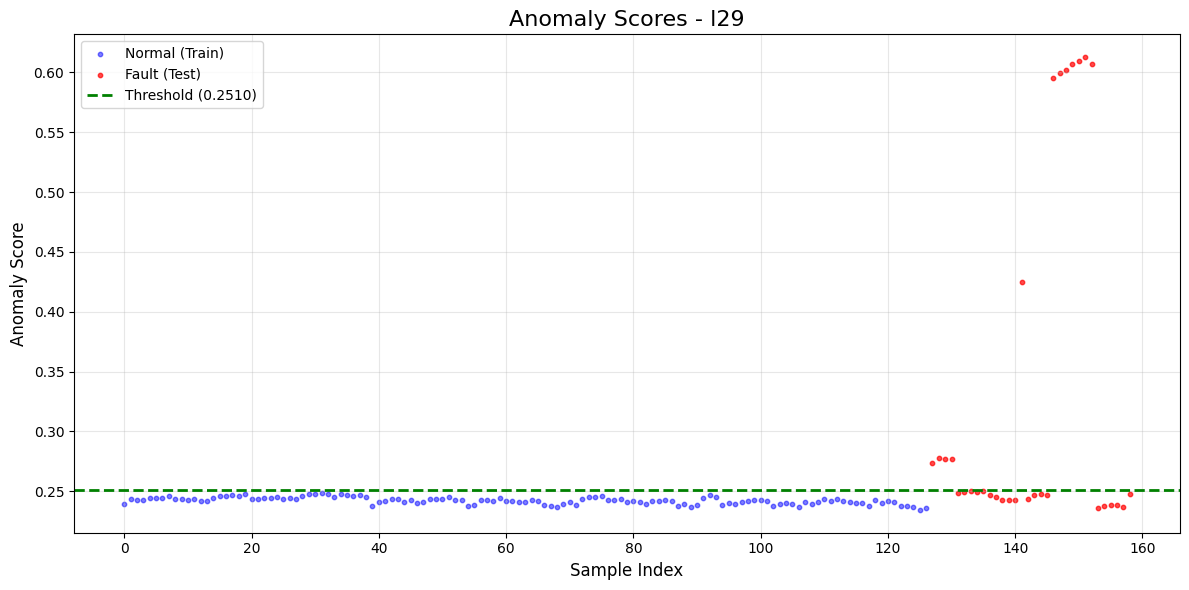

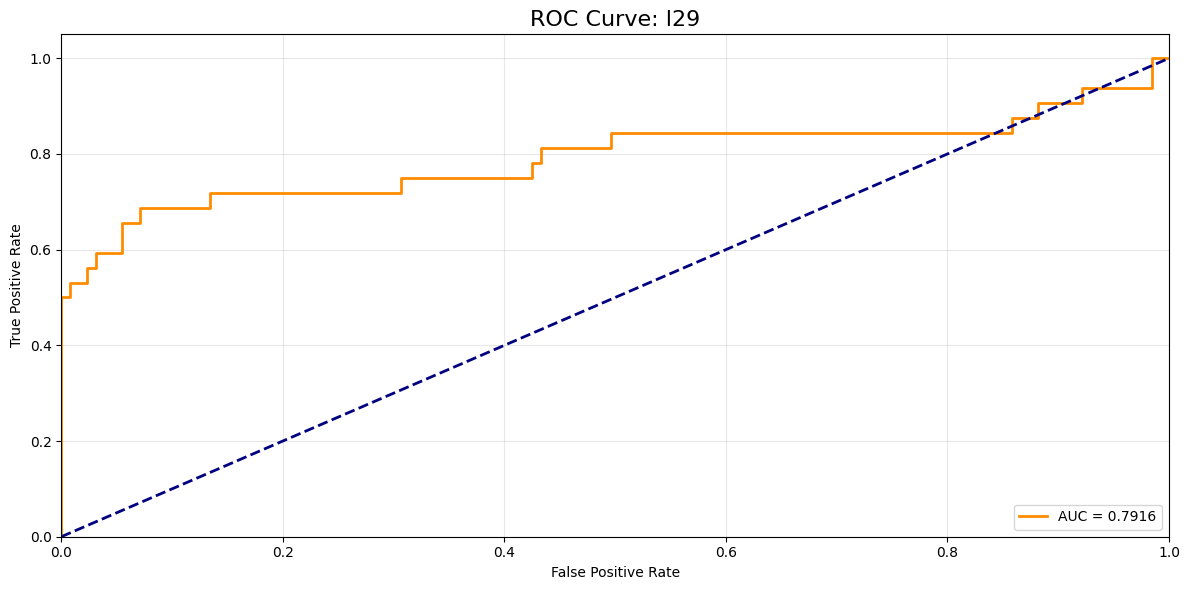


🚀 Experiment [l31] 학습 및 평가 시작
✅ [l31] 모델 학습 완료
📊 [l31] 최종 결과
   - Normal 샘플 수: 86
   - Fault 샘플 수 : 6
   - AUROC Score   : 0.9612


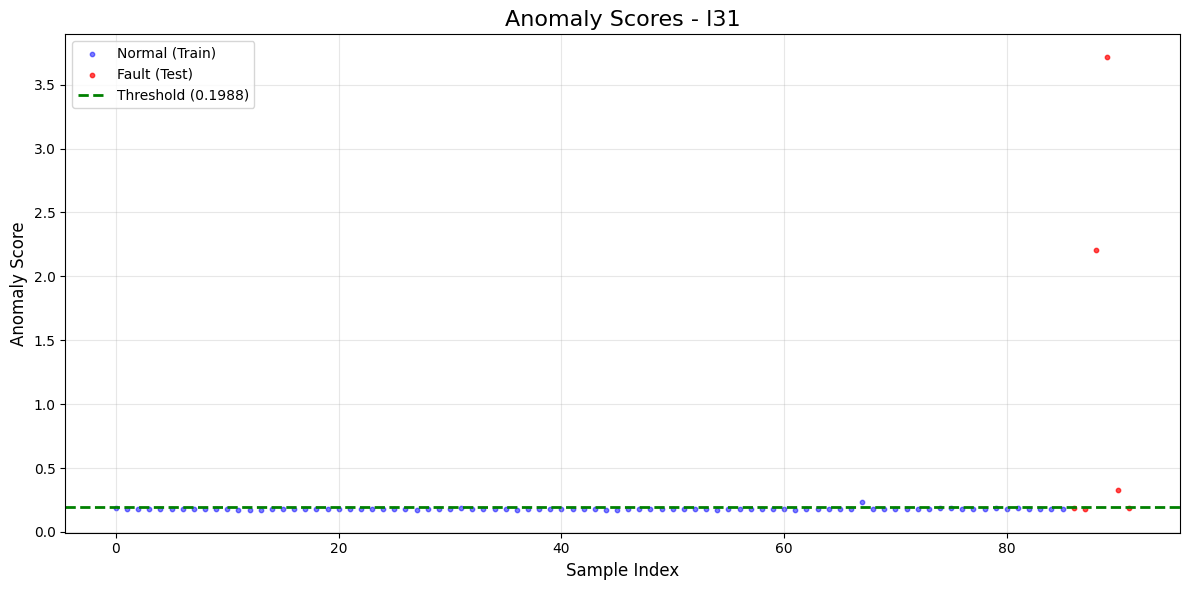

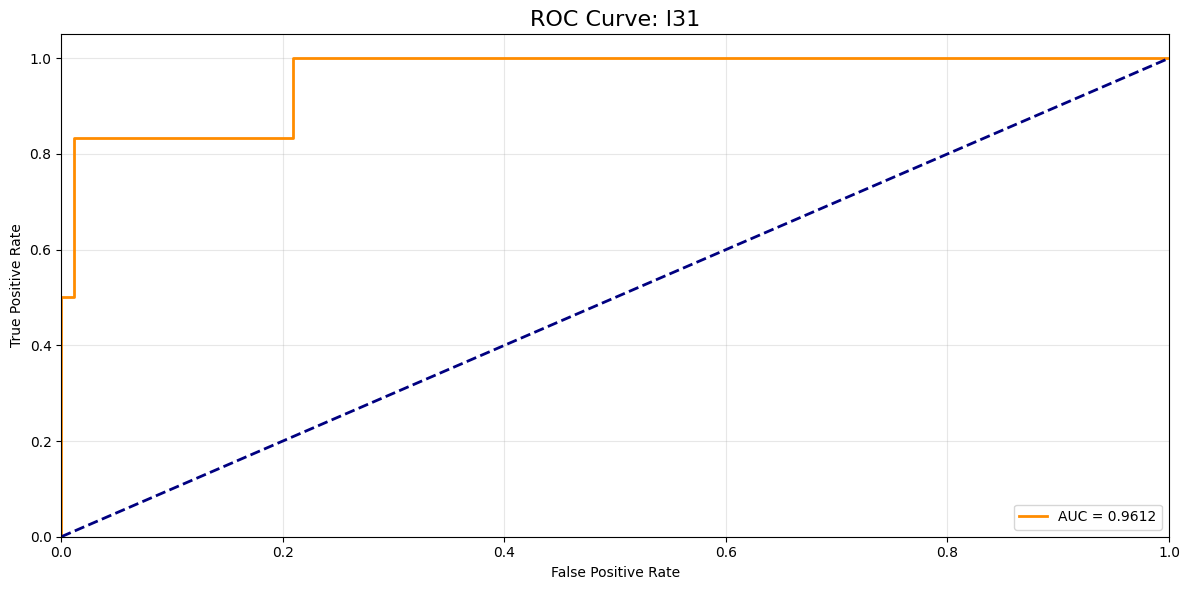


🚀 Experiment [l33] 학습 및 평가 시작
✅ [l33] 모델 학습 완료
📊 [l33] 최종 결과
   - Normal 샘플 수: 45
   - Fault 샘플 수 : 18
   - AUROC Score   : 0.8728


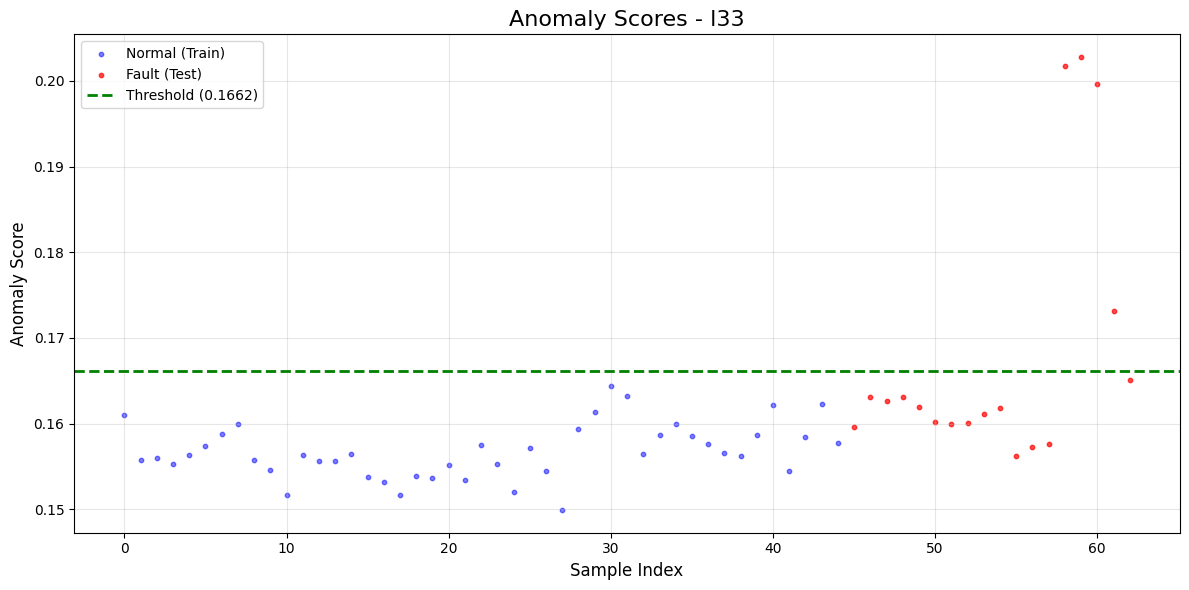

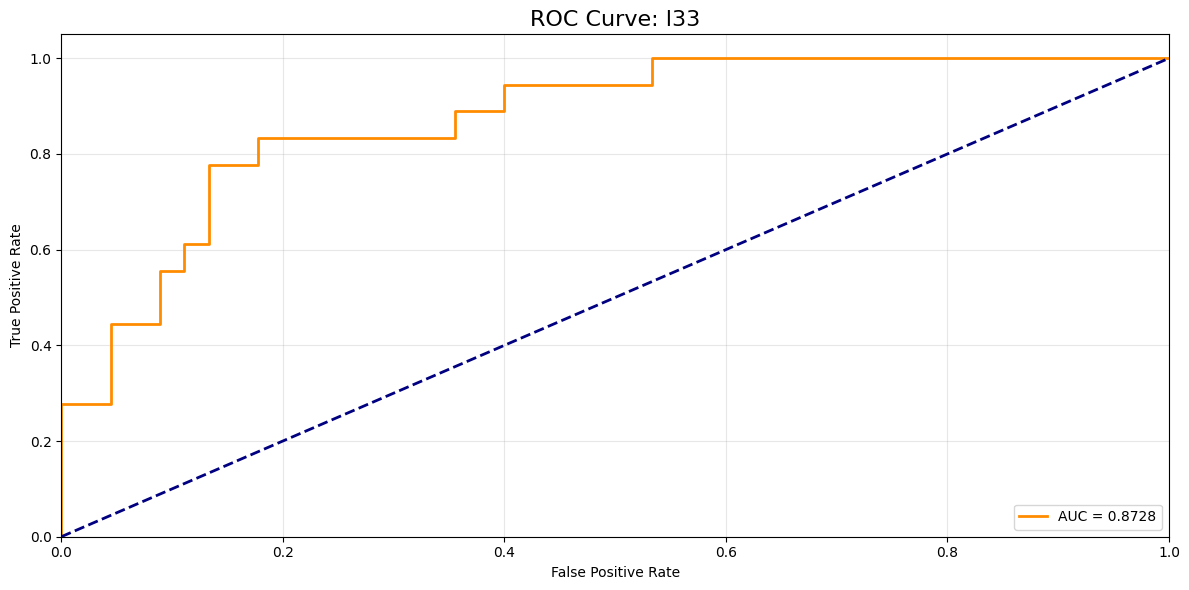


🏆 전체 실험 요약 (AUC Score)
Experiment l29: 0.7916
Experiment l31: 0.9612
Experiment l33: 0.8728


<Figure size 640x480 with 0 Axes>

In [35]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np


# ==========================================
# 1. 하이퍼파라미터 및 설정
# ==========================================
BATCH_SIZE = 32
NUM_EPOCHS = 50       # 학습 에폭 수 (필요에 따라 조절)
LATENT_DIM = 10       # USAD Latent Dimension
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device: {device}")
print(f"Experiments: {experiments}")


# 결과를 저장할 딕셔너리
final_results = {}

# 그래프 설정 (1행 3열)
plt.figure(figsize=(18, 5))

# ★ ROC Curve를 그릴 전체 캔버스 미리 생성 및 ID 저장
roc_fig = plt.figure(figsize=(18, 5))


# ==========================================
# 2. 실험별 학습 및 평가 루프
# ==========================================

for idx, exp_id in enumerate(experiments):
    print(f"\n" + "="*50)
    print(f"🚀 Experiment [{exp_id}] 학습 및 평가 시작")
    print("="*50)

    # 1) 데이터셋 가져오기
    if exp_id not in datasets:
        print(f"⚠️ [{exp_id}] 데이터가 datasets 딕셔너리에 없습니다. 건너뜁니다.")
        continue

    data_dict = datasets[exp_id]
    X_train = data_dict['train']      # 학습용 (Normal)
    X_test_fault = data_dict['test_fault'] # 테스트용 (Fault)

    if len(X_train) == 0:
        print(f"⚠️ [{exp_id}] 학습 데이터가 비어있습니다.")
        continue


    # 2) Tensor 변환 및 DataLoader 생성
    input_dim = X_train.shape[1] * X_train.shape[2]
    train_tensor = torch.FloatTensor(X_train)

    if len(X_test_fault) > 0:
        test_fault_tensor = torch.FloatTensor(X_test_fault)
    else:
        test_fault_tensor = torch.FloatTensor([])


    train_loader = DataLoader(TensorDataset(train_tensor), batch_size=BATCH_SIZE, shuffle=True)
    eval_train_loader = DataLoader(TensorDataset(train_tensor), batch_size=BATCH_SIZE, shuffle=False)

    if len(test_fault_tensor) > 0:
        eval_test_loader = DataLoader(TensorDataset(test_fault_tensor), batch_size=BATCH_SIZE, shuffle=False)

    # 3) 모델 초기화 & 학습
    model = USAD(w_size=input_dim, z_size=LATENT_DIM)
    model = train_usad(model, train_loader, num_epochs=NUM_EPOCHS, device=device)
    print(f"✅ [{exp_id}] 모델 학습 완료")

    # 4) 추론 및 점수 계산
    train_scores = evaluate_usad(model, eval_train_loader, device=device)

    if len(test_fault_tensor) > 0:
        test_scores = evaluate_usad(model, eval_test_loader, device=device)
    else:
        test_scores = []
        print(f"⚠️ [{exp_id}] 불량 테스트 데이터가 없어 AUC를 계산할 수 없습니다.")

    # 5) 성능 평가 (AUC) 및 시각화
    if len(test_scores) > 0:
        y_true = np.concatenate([np.zeros(len(train_scores)), np.ones(len(test_scores))])
        y_scores = np.concatenate([train_scores, test_scores])

        auc_score = roc_auc_score(y_true, y_scores)
        final_results[exp_id] = auc_score

        print(f"📊 [{exp_id}] 최종 결과")
        print(f"   - Normal 샘플 수: {len(train_scores)}")
        print(f"   - Fault 샘플 수 : {len(test_scores)}")
        print(f"   - AUROC Score   : {auc_score:.4f}")


        # 임계값 계산 (Mean + 3*Std)
        threshold = np.mean(train_scores) + 3 * np.std(train_scores)
        plot_anomaly_scores(train_scores, test_scores, threshold, exp_id)


        fpr, tpr, _ = roc_curve(y_true, y_scores)

        # (수정) subplot 대신 새로운 figure 생성 (가로 12, 세로 6)
        plt.figure(figsize=(12, 6))

        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc_score:.4f}')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve: {exp_id}', fontsize=16)
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show() # 즉시 출력

    else:
        plt.figure(roc_fig.number)
        plt.subplot(1, 3, idx+1)
        plt.title(f'{exp_id}: No Test Data')


# ==========================================
# 3. 전체 결과 요약 출력
# =========================================

print("\n" + "="*50)
print("🏆 전체 실험 요약 (AUC Score)")
print("="*50)
for exp_id, score in final_results.items():
    print(f"Experiment {exp_id}: {score:.4f}")



# 마지막으로 ROC 그래프 전체 출력
plt.figure(roc_fig.number)
plt.tight_layout()
plt.show()

